In [1]:
%matplotlib inline

# COVID-19 Моделирование распространения и анализ

Целью данной лабораторной является построение модели заболевания населения COVID-19, обладающей как можно лучшей предсказательной силой. Каждый студент может на свое усмотрение выбрать факторы, учитываемой моделью, по результатам семестра проводится конкурс на лучшую модель. 

### Ход выполнения работы

1. Изучение теории и имеющихся данных. 

1. Формулировка гипотез о связах величин и законах их изменения.

1. Построение математической модели, нахождение аналитических решений, написание кода для симуляции.

1. Качественное сравнение результатов модели и реальных данных.

1. Оценивание параметров модели на основе реальных данных. 

1. Количественное сравнение предсказаний модели с историческими данными.

1. Извелечение практически полезной информации, например, оценка продолжительности болезни, [индекса репродукции](https://ru.wikipedia.org/wiki/Индекс_репродукции), скорости снижения иммунитета, тенденции изменения этих параметров, формирование сценариев дальнейшего развития ситуации с COVID-19.

1. Предложения по добавлению управляющих параметров, таких как введение каратнинов, и разработка алгоритма, позволяющего добиться контроля над распространением ковида.  

## Исходные данные по COVID-19

1. [COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19) [Визуализация данных](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6)

1. [Kouprianov, A. (2021). COVID-19.SPb.monitoring. Monitoring COVID-19 epidemic in St. Petersburg, Russia: Data and scripts.](https://github.com/alexei-kouprianov/COVID-19.SPb.monitoring) [Данные по всей России.](https://github.com/alexei-kouprianov/COVID.2019.ru/)

1. [Coronavirus (Covid-19) Data in the United States](https://github.com/nytimes/covid-19-data)

1. [Our World in Data](https://github.com/owid/covid-19-data) Данные по избыточной смертности по месяцам. [Визуализация данных](https://ourworldindata.org/coronavirus)

1. [Oxford Covid-19 Government Response Tracker](https://github.com/OxCGRT/covid-policy-tracker)

1. [Яндекс. Коронавирус: дашборд](https://datalens.yandex/7o7is1q6ikh23?tab=X1&utm_source=cbmain) [Данные на карте.](https://yandex.ru/maps/covid19?ll=41.775580%2C54.894027&z=3)

1. [Excess mortality during the COVID-19 pandemic](https://github.com/dkobak/excess-mortality)

## Публикации про данные

1. [Что важно знать гражданам Санкт-Петербурга об эпидемии коронавируса.](https://github.com/alexei-kouprianov/COVID-19.SPb.monitoring/blob/main/texts/SPb.COVID-19.overview.md) [COVID-19 в Петербурге, сводный инфографический отчет.](https://github.com/alexei-kouprianov/COVID-19.SPb.monitoring/blob/main/texts/SPb.COVID-19.r_report.md) [Фонтанка: Волна идет на подъем? О чем молчит официальная ковидная статистика в Петербурге](https://www.fontanka.ru/2021/09/08/70123958/)

## Данные о возрастной пирамиде

1. [PopulationPyramid.net](https://www.populationpyramid.net/ru/%D1%80%D0%BE%D1%81%D1%81%D0%B8%D1%8F/2020/)

1. [Росстат: Численность населения Российской Федерации по муниципальным образованиям](https://rosstat.gov.ru/compendium/document/13282)

In [2]:
# Устанавливаем библиотеки, если это не было сделано ранее.
# ! pip3 install seaborn matplotlib numpy pandas

In [3]:
# Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
import seaborn as sns

# Используем настройки seaborn по-умолчанию, устанавливаем только размер рисунка
sns.set(rc={'figure.figsize':(11, 4)})

In [4]:
# Загрузка данных агрегированных А. Куприяновым.
# URL = 'https://raw.githubusercontent.com/alexei-kouprianov/COVID-19.SPb.monitoring/main/data/SPb.COVID-19.united.csv'
# urllib.request.urlretrieve(URL, 'data/SPb.COVID-19.united.csv')

In [5]:
# Читаем локальную копию файла
data = pd.read_csv('data/SPb.COVID-19.united.csv', na_values='NA', parse_dates=[0,5], index_col=0)
# Выводим названия столбцов и типы
print(data.dtypes)
# Выводим размер таблицы
print(data.shape)

CONFIRMED.sk                                  int64
RECOVERED.sk                                  int64
DEATHS.sk                                     int64
ACTIVE.sk                                     int64
DATE.spb                             datetime64[ns]
CONFIRMED.spb                               float64
RECOVERED.spb                               float64
ACTIVE.spb                                  float64
IN_HOSPITALS.spb                            float64
HOSPITALIZED_TODAY.spb                      float64
PCR_TESTS                                   float64
V1.CS                                       float64
V1.TODAY                                    float64
V2.CS                                       float64
V2.TODAY                                    float64
V.REMAINING                                 float64
DESIGNATED_BEDS                             float64
VENT                                        float64
VR1.CS                                      float64
VR1.TODAY   

In [6]:
# Визуально проверяем корректность загруженных данных
# data

Так как имеющиеся данные описывают только изменение численности больших классов людей, то анализ этих данных будем проводить в духе [SIR модели](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology).
Всех людей мы объединяем в классы: S - восприимчивые к болезни, I - зараженные/болеющие, R - невосприимчивые к болезни/выздоровевшие/погибшие. 
Число больных I доступно в инсторических данных непосредственно в поле `ACTIVE.sk`, все данные приводятся с шагом в день. Числа S и R непосредственно не доступны, однако у нас есть данные о переходах между классами: 
- Поле `CONFIRMED.sk` содержит число заболевших, т.е. перешедших из класса S в класс I. 
- Поле `RECOVERED.sk` содержит число выздоровевших, а поле `DEATHS.sk` число погибших. Их сумма равна числу перешедших из класса I в класс R.

Значение `ACTIVE.sk` теоретически можно вычислить через поля `CONFIRMED.sk`, `RECOVERED.sk`, `DEATH.sk`, практически же сохраненные значения и вычисленные могут немного различаться. 

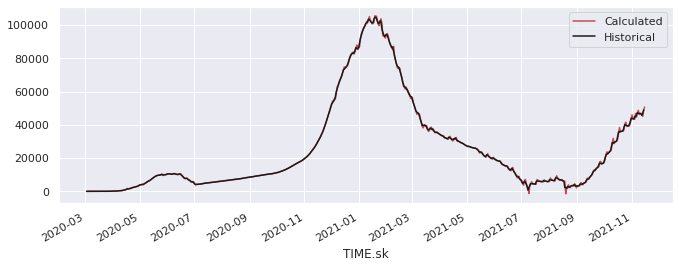

In [7]:
(data['ACTIVE.sk']+data['CONFIRMED.sk']-data['RECOVERED.sk']-data['DEATHS.sk']).plot(style='-r', label='Calculated')
(data['ACTIVE.sk'].shift(-1)).plot(style='k', label='Historical')
plt.legend()
plt.show()

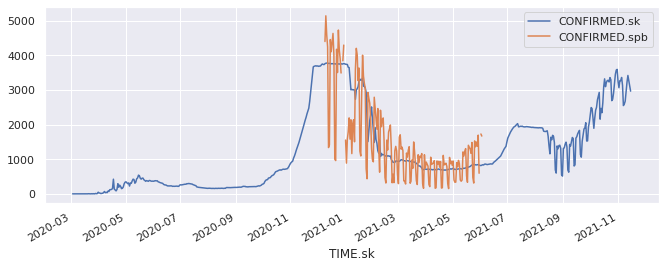

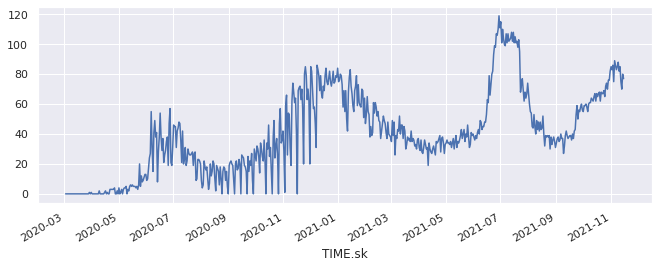

In [8]:
# Посмотрим, как изменялись число заражений и число смертей.
data[['CONFIRMED.sk','CONFIRMED.spb']].plot(subplots=False)
plt.show()

data['DEATHS.sk'].plot(subplots=True)
plt.show()


In [9]:
# Мы видим колебания статистики в течении недели, возникающие из-за особенностей сбора данных.
# Просуммируем данные за каждую неделю, что уменьшит шум.

data7 = data.resample('7D').sum()

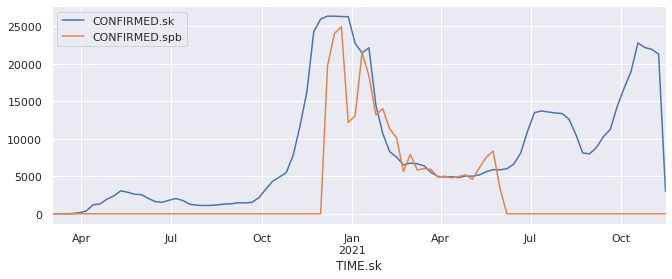

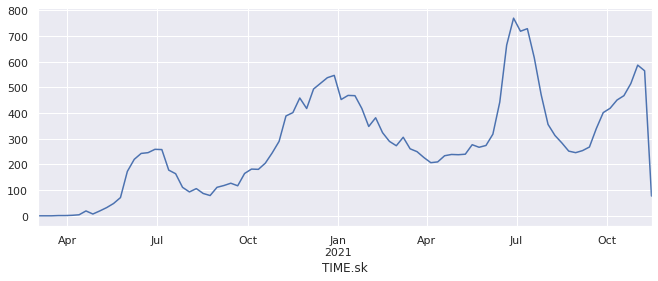

In [10]:
data7[["CONFIRMED.sk","CONFIRMED.spb"]].plot(subplots=False)
plt.show()
data7["DEATHS.sk"].plot(subplots=False)
plt.show()

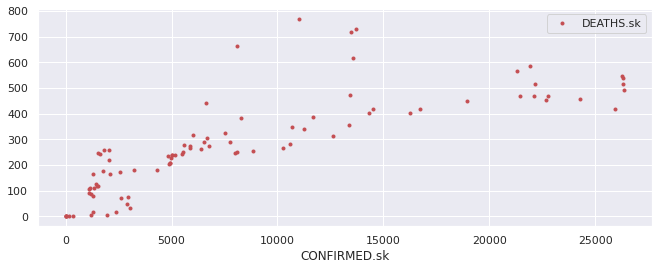

In [11]:
# Посмотрим, как число больных связано со смертностью.
data7.plot(x="CONFIRMED.sk",y="DEATHS.sk", style='.r')
plt.show()

В имеющихся у нас данных нет переходов из класса R в класс S, что соответствует потере иммунитета со временем.
По оценкам иммунологов иммунитет должен сохраняться хотя бы в течении 6 месяцев, причем иммуный человек заболевает со значительно меньшей вероятностью, поэтому во время первой волны заболеваний ковидом переходами R -> S можно пренебречь. 

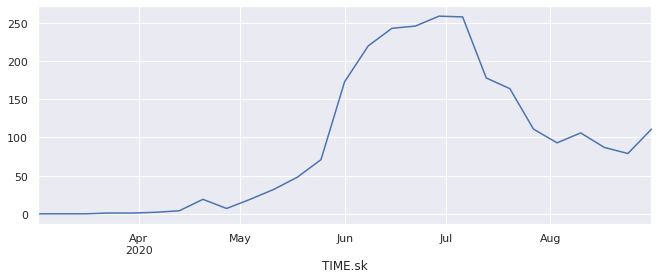

In [12]:
# Извлечем данные по первой полне
first_wave = data7.loc[:'2020-09-01']

# Проверим визуально, что данные по смертям действительно показывают одну волну.
first_wave['DEATHS.sk'].plot()
plt.show()

Для понимания происходящего и предсказания будущего нам нужна модель, описывающая связь между наблюдаемыми величинами.
Всплески заболеваемости и последующее уменьшение числа болеющих можно описать простейшей SIR моделью, в рамках которой вся попопуляция разбивается на группы: S - восприимчивые к инфекции, I - болеющие, R - невосприимчивые к инфекции. 
Внутри каждой группы люди считаются одинаково реагирующими на инфекцию, также считается, что любой человек может заразить любого, т.е. популяция однородна. 
Эти допущения не вполне соответствуют действительности, зато позволяют сформулировать простую модель, точность предсказаний которой мы попробуем проверить. 
В начале число больных I весьма мало, и все люди попадают в группу людей S, рискующих заболеть.
В процессе инфицирования люди из группы S постепенно перетекают в группу I, причем скорость перетекания увеличивается как с увеличением числа больных I, так и с числом людей S, которых можно заразить.
В первом приближении можно считать скорость заболеваемости пропорциональной доле больных $I/N$ и не болевших $S/N$, с коэффициентом пропорциональности $\beta$.
Больные люди со временем выздоравливают и приобретают иммунитет, причем в модели мы считаем, что люди с иммунитетом не заболевают. 
Людей с иммунитетом мы относим в группу R, также в эту группу попадают погибшие.
В модели мы приближенно считаем, что за единицу времени выздоравливает определенная доля $\gamma$ болеющих. 

[SIR модель](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model_without_vital_dynamics) описывается системой дифференциальных уравнений:
$$
\begin{cases}
\frac{dS}{dt} = -\frac{\beta I S}{N},\\
\frac{dI}{dt} = \frac{\beta I S}{N}-\gamma I,\\
\frac{dR}{dt} = \gamma I. 
\end{cases}
$$

Полное число людей $N=S+I+R$ в этой модели постоянно.
По данным Росстата население Петербурга на 1 января 2021 составило $N=5 384 342$ человек.

Направление изменения числа больных определяется базовым [индексом репродукции](https://ru.wikipedia.org/wiki/Индекс_репродукции) $\rho_0=\frac{\beta}{\gamma}$.
Из второго уравнения 
$$\frac{dI}{dt} = \gamma I \left(\rho_0\frac{S}{N}-1\right).$$
Величина $\rho=\rho_0(1-\frac{R+I}{N})=\rho_0\frac{S}{N}$ называется эффективным репродуктивным числом
и равна числу заражений одним инфицированным.  
Если $\rho<1$, то число больных уменьшается и эпидемия идет на спад.
Если $\rho>1$, то идет экспоненциальный рост числа больных. 
Так как эффективное репродуктивное число зависит от числа неинфицированных людей, 
то можно вычислить минимальное необходимое число людей с иммунитетом для предотвращения роста числа заражений,
т.е. для достижения [коллективного иммунитета](https://ru.wikipedia.org/wiki/Коллективный_иммунитет):
$$
\rho<1\quad\Leftrightarrow\quad 
1-\frac{1}{\rho_0}<\frac{R+I}{N}.
$$

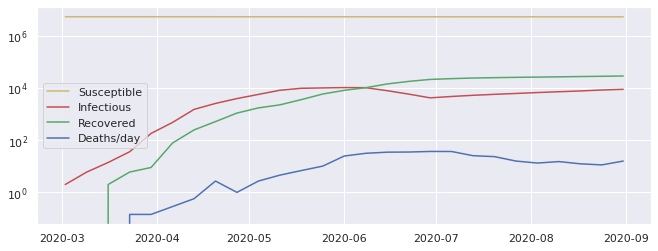

In [13]:
# Вычислим из доступных данных величины из SIR модели.
# Число невосприимчивых.
R = (first_wave['RECOVERED.sk']+first_wave['DEATHS.sk']).cumsum()
# Всего людей
N = 5384342
# Число восприимчивых
S = N - first_wave['CONFIRMED.sk'].cumsum()
# Число больных
I = N - S - R
# Число умирающих в день.
dD = first_wave['DEATHS.sk']/7


# В первую волну заболело только небольшое число жителей города, поэтому S почти не изменяется. 
plt.semilogy(S, 'y', label='Susceptible') 
plt.semilogy(I, 'r', label='Infectious')
plt.semilogy(R, 'g', label='Recovered')
plt.semilogy(dD, 'b', label='Deaths/day')
plt.legend()
plt.show()


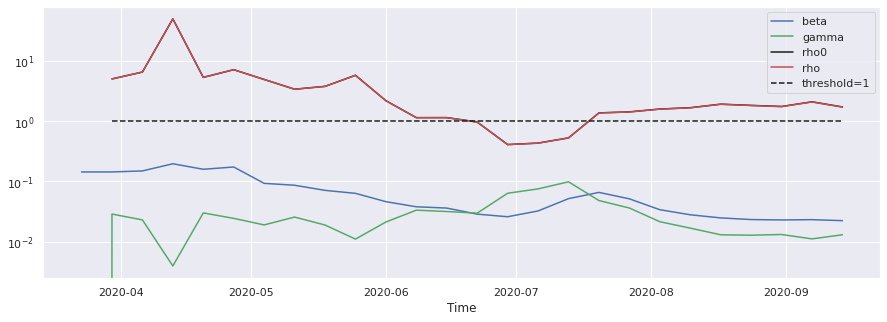

In [14]:
# Заменив производные в уравнениях SIR модели на конечные разности мы можем оценить
# константы модели в каждый момент времени.
# Даты между датами в индексе.
index = first_wave.index.shift(periods=3)[:-1]
# Вычислим производные и средние значения на интервалах.
dS = pd.Series( np.diff(S.to_numpy(), 1)/7, index=index)
dI = pd.Series( np.diff(I.to_numpy(), 1)/7, index=index)
dR = pd.Series( np.diff(R.to_numpy(), 1)/7, index=index)
def midpoint(x): return pd.Series( (x[1:]+x[:-1])/2, index=index)
mS = midpoint(S.to_numpy())
mI = midpoint(I.to_numpy())
mR = midpoint(R.to_numpy())

# Выразим константы.
beta = -dS/mS/mI*N
gamma = dR/mI
rho0 = beta/gamma # Basic reproduction number
rho = rho0*mS/N # Effective reproduction number

fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(beta, 'b', label='beta')
ax.plot(gamma, 'g', label='gamma')
ax.semilogy(rho0, 'k', label='rho0')
ax.semilogy(rho, 'r', label='rho')
ax.semilogy(1+0*rho, '--k', label='threshold=1')
ax.set_xlabel("Time")
ax.legend()
plt.show()

[Нерабочие дни](https://ru.wikipedia.org/wiki/Хронология_событий_в_России,_вызванных_пандемией_COVID-19) вводились с 30 марта по 30 апреля. Именно на это время приходится скачок индекса репродукции. Согласно нашей оценке индекс репродукции оставался больше единицы до середины июня. 

Исходные данные очень зашумлены, поэтому наши оценки параметров модели по паре точек весьма приблизительны. 
Если предположить, что константы не менялись на всем рассматриваемом промежутке, то параметры можно оценить опираясь на все совокупность данных, значительно уменьшая шум. 
Для корректной оценки нам нужна некоторая модель шума. 
Рассмотрем простейшую модель, в которой скорость изменения числа людей в каждой группе определяется по SIR модели, но в каждый момент возможны отклонения от модели, которые в среднем равны нулю и независимы между собой.
$$
\begin{cases}
\dot S=\frac{dS}{dt} = -\frac{\beta I S}{N}+W_S,\\
\dot I=\frac{dI}{dt} = \frac{\beta I S}{N}-\gamma I+W_I,\\
\dot R=\frac{dR}{dt} = \gamma I+W_R. 
\end{cases}
$$
Для каждого момента времени $t$ в уравнения входят свои случайные величины $W_S$, $W_I$ и $W_R$,
такие что они не зависят друг от друга и от себя при других $t$.
Математическое ожидание всех шумов $W_\cdot$ равно нулю, и для простоты предположим, что
они все распределены нормально со среднеквадратическим отклонением $1$.
Тогда логарифмическая [функция правдоподобия](https://ru.wikipedia.org/wiki/Функция_правдоподобия) равна:
$$
\log L[\beta,\gamma]=-\int_{T_1}^{T_2}[(\dot S+\beta IS/N)^2 +(\dot I-\beta IS/N+\gamma I)^2+(\dot R-\gamma I)^2]dt.
$$
Согласно принципу [максимального правдоподобия](https://ru.wikipedia.org/wiki/Метод_максимального_правдоподобия)
параметры можно найти как точку максимума функции правдоподобия:
$$
\beta,\gamma = \mathrm{argmax}_{\beta,\gamma} \log L[\beta,\gamma],
$$
где функции $S$, $I$ и $R$ берутся из исторических данных.
Для нашего выбора распределения шумов, задача сводится к методу [наименьших квадратов](https://ru.wikipedia.org/wiki/Метод_наименьших_квадратов).

## Дополнительные вопросы для любопытных

1. Оцените эффективность введения локдауна весной 2020 года. Произведите сначала оценку на основе данных по смертности и заболеваемости. Затем проверьте вывод на основе данных Яндекс об индексе самоизоляции по регионам.

1. Оцените необходимую долю вакцинированного населения для достижения группового иммунитета весной 2020-го и летом 2021 (штам дельта).

1. Вычислите и сравните заразности штаммов COVID-19 в 2020 и в 2021 годах. Как изменилась смертность от COVID-19?

1. Доступные данные по-всей видимости содержат ошибки в сотни процентов. Как можно уменьшить ошибки? Какие выводы все-таки можно сделать?

1. Предположив некоторую модель отклонения числа заболеваний/смертей от скользящего среднего, используйте модель для оценки достоверности данных. Какие данные обладают признаками недостоверности? Чем это можно объяснить?

1. Попробуйте восстановить отсутствующие данные, построив математическую модель и натренировав ее на имеющихся данных. Оцените реальное число переболевших.

1. Оцените, насколько надежно данные о числе запросов про ковид в поисковых системах отражает реальное число заболеваний. Можно ли использовать данные о числе запросов для уточнения статистики?

1. Какие меры предложили бы вы для скорейшего завершения пандемии?

1. Швеция не вводила жесткий локдаун, но смертность в Швеции во время пандемии выросла слабо. Как вы можете это объяснить? Подкрепите свои выводы данными и моделированием.


